In [251]:
import cv2
import sys
import numpy as np
import matplotlib.pyplot as plt
import sys
PY3 = sys.version_info[0] == 3

if PY3:
    xrange = range

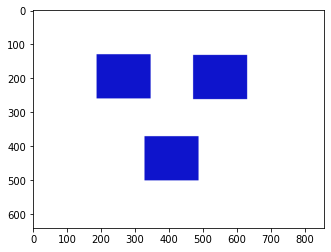

In [252]:
img_bgr = cv2.imread("3squares.png", cv2.IMREAD_COLOR)
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb)

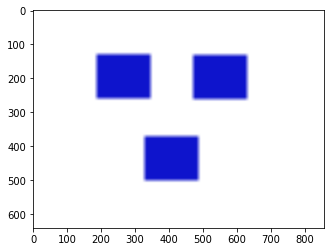

In [253]:
frame = img_rgb
frame_blur = cv2.blur(frame, (13,13))
plt.imshow(frame_blur)

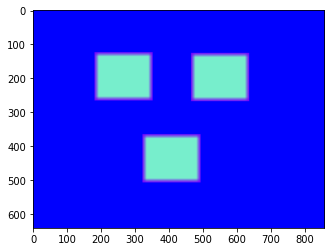

In [254]:
frame_hsv = cv2.cvtColor(frame_blur, cv2.COLOR_RGB2HSV)
plt.imshow(frame_hsv)

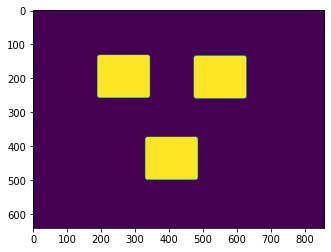

In [255]:
frame_thresh = cv2.inRange(frame_hsv, (105,150,80), (130,255,255))
plt.imshow(frame_thresh)

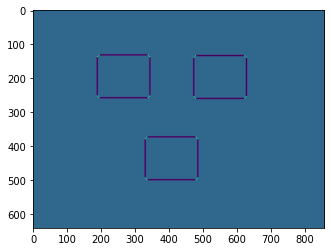

In [256]:
frame_dst = cv2.cornerHarris(frame_thresh, 5,3,0.04)
plt.imshow(frame_dst)

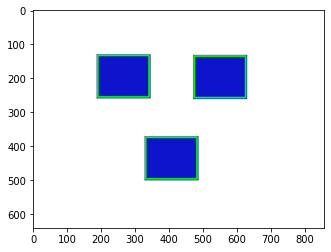

In [257]:
ret, dst = cv2.threshold(frame_dst, 0.1*frame_dst.max(),255,0)
dst= np.uint8(dst)
ret, labels, stats, centroids = cv2.connectedComponentsWithStats(dst)
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.001)
corners = cv2.cornerSubPix(frame_thresh,np.float32(centroids),(5,5),(-1,-1),criteria)
#SQUARE 1:
## Corners[1,2,6,5]
#SQUARE 2:
## Corners[3,4,8,7]
#SQUARE 3:
## Corners[9,10,12,11]
corners = corners.astype('intc')
squareFromCorners = np.array([[corners[1],corners[2],corners[6],corners[5]],[corners[3],corners[4],corners[8],corners[7]],[corners[9],corners[10],corners[12],corners[11]]])
cv2.drawContours(img_bgr, squareFromCorners, -1, (0,255,0), 3)
plt.imshow(img_bgr[:,:,::-1])

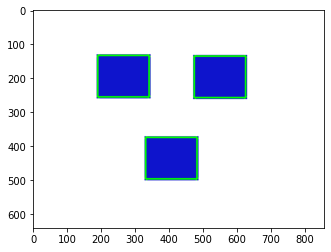

In [258]:
img_bgr[dst>0.1*dst.max()]=[0,255,0]
plt.imshow(img_bgr[:,:,::-1])

In [259]:
def angle_cos(p0,p1,p2):
    d1, d2 = (p0-p1).astype('float'), (p2-p1).astype('float')
    return abs( np.dot(d1, d2) / np.sqrt( np.dot(d1, d1)*np.dot(d2, d2) ) )

def findShapes(img):
    corners = dst>0.1*dst.max()
    squares = []
    for gray in cv2.split(img):
        for thrs in xrange(0,255,26):
            if thrs == 0:
                bin = cv2.Canny(gray, 0, 50, apertureSize=5)
                bin = cv2.dilate(bin, None)
            else:
                _retval, bin = cv2.threshold(gray, thrs, 255, cv2.THRESH_BINARY)
            contours, _hierarchy = cv2.findContours(bin, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
            for cnt in contours:
                cnt_len = cv2.arcLength(cnt, True)
                cnt = cv2.approxPolyDP(cnt, 0.02*cnt_len, True)
                if len(cnt) == 4 and cv2.contourArea(cnt) > 1000 and cv2.isContourConvex(cnt):
                    cnt = cnt.reshape(-1, 2)
                    max_cos = np.max([angle_cos( cnt[i], cnt[(i+1) % 4], cnt[(i+2) % 4] ) for i in xrange(4)])
                    if max_cos < 0.08:
                        squares.append(cnt)
    return squares

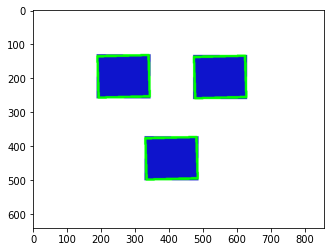

In [260]:
img_bgr = cv2.imread("3squares.PNG", cv2.IMREAD_COLOR)
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
shapes = findShapes(frame_thresh)
cv2.drawContours(img_rgb, shapes, -1, (0,255,0), 3)
plt.imshow(img_rgb)
# print(len(shapes))
# print(shapes[0])
# print(type(shapes[0][0][0]))
# print(shapes)

[190 133] [341 133] [341 255] [190 255]
[190 133]
[341 133]
[341 255]
[190 255]


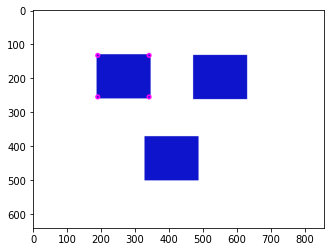

In [261]:
print(squareFromCorners[0][0], squareFromCorners[0][1], squareFromCorners[0][2], squareFromCorners[0][3])
shape = squareFromCorners[0]
for s in shape:
    print(s)
    cv2.circle(img_bgr, s, 5, (255,0,255), 3)
plt.imshow(img_bgr[:,:,::-1])
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)

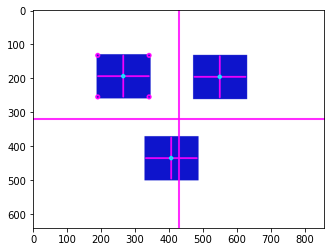

In [262]:
from statistics import mean
centers = []
for shape in squareFromCorners:
    left_mid = (mean([shape[0][0], shape[3][0]]), mean([shape[0][1], shape[3][1]]))
    right_mid = (mean([shape[1][0], shape[2][0]]), mean([shape[1][1], shape[2][1]]))
    top_mid = (mean([shape[0][0], shape[1][0]]), mean([shape[0][1], shape[1][1]]))
    bot_mid = (mean([shape[2][0], shape[3][0]]), mean([shape[2][1], shape[3][1]]))
    cv2.line(img_rgb, left_mid, right_mid, (255,0,255), 3)
    cv2.line(img_rgb, top_mid, bot_mid, (255,0,255), 3)
    center = (mean([left_mid[0], right_mid[0]]), mean([top_mid[1], bot_mid[1]]))
    centers.append(center)
    cv2.circle(img_rgb, center, 4, (0,255,255), 3)

img_rgb_copy = img_rgb.copy()

num_rows, num_cols = img_rgb.shape[:2]

cv2.line(img_rgb_copy, (num_cols//2,0), (num_cols//2,num_cols), (255,0,255), 3)
cv2.line(img_rgb_copy, (0,num_rows//2), (num_cols,num_rows//2), (255,0,255), 3)

plt.imshow(img_rgb_copy)

In [264]:
from math import sqrt
img_center = (num_rows//2, num_cols//2)
min = -1
indx = -1

for idx,c in enumerate(centers):    
    row_dist = img_center[1] - c[0]
    col_dist = img_center[0] - c[1]
    if min == -1:
        min = sqrt(row_dist**2 + col_dist**2)
    else:
        dist = sqrt(row_dist**2 + col_dist**2)
        if dist < min:
            min = dist
            indx = idx

if indx != -1:
    row_dist = img_center[1] - centers[indx][0]
    col_dist = img_center[0] - centers[indx][1]
    ## TODO:
    # Change here for what distance from center point it should recorrect itself
    if sqrt(row_dist**2 + col_dist**2) > 6:
        ## TODO:
        # Sent over UART to MSP distances from center and calculated recorrecting steps
        print((row_dist, col_dist))

(23, -115)


In [263]:
# from math import sqrt

# # The number of pixels
# num_rows, num_cols = img_rgb.shape[:2]

# img_center = (num_rows//2, num_cols//2)

# min = -1
# indx = -1

# for idx,c in enumerate(centers):
#     row_dist = img_center[0] - c[0]
#     col_dist = img_center[0] - c[1]
#     if min == -1:
#         min = sqrt(row_dist**2 + col_dist**2)
#     else:
#         dist = sqrt(row_dist**2 + col_dist**2)
#         if dist < min:
#             min = dist
#             indx = idx


# row_dist = img_center[0] - centers[indx][0]
# col_dist = img_center[1] - centers[indx][1]

# # Creating a translation matrix
# translation_matrix = np.float32([ [1,0,row_dist], [0,1,col_dist] ])

# # Image translation
# img_translation = cv2.warpAffine(img_rgb, translation_matrix, (num_cols,num_rows))

# cv2.line(img_translation, (num_cols//2,0), (num_cols//2,num_cols), (255,0,255), 3)
# cv2.line(img_translation, (0,num_rows//2), (num_cols,num_rows//2), (255,0,255), 3)

# plt.imshow(img_translation)

